Supervised ML Map

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

from sklearn.metrics import classification_report, accuracy_score
from tkinter import Tk
from tkinter.filedialog import asksaveasfilename

from catboost import CatBoostClassifier, Pool

In [106]:
#SET DIRECTORY
os.chdir(r'C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200px_larger_2\checkered_data_200')

In [107]:
#IMPORT CHECKERED TEST DATA, DROP LAYERS IF NEEDED
df_test = pd.read_parquet('checker0_df.parquet')
#df.drop('LINE_M61_Centro_FAULTS', axis=1, inplace=True)

df = pd.read_parquet('checker1_df.parquet')
#df_test.drop('LINE_M61_Centro_FAULTS', axis=1, inplace=True)

In [108]:
#Check which columns are not float
non_float_columns = df.select_dtypes(exclude=['float64']).columns
print("Non-float columns:", non_float_columns)

#DEFINE TARGET COLUMN

target_column = 'TARGET_M162-Deposits_CLIPPED'

df[target_column] = (df[target_column]).astype(int)

df[target_column].dtype

Non-float columns: Index(['M61_Centro_GEOL_lithology', 'TARGET_M162-Deposits_CLIPPED'], dtype='object')


dtype('int32')

In [109]:
#TRAIN ALGORITHM

feature_columns = [col for col in df.columns if col != target_column]

# Updated: Identify categorical columns (object dtype or categorical)
categorical_features_indices = [i for i, col in enumerate(feature_columns)
                                if df[col].dtype == 'object' or isinstance(df[col].dtype, pd.CategoricalDtype)]

# Prepare features and target
X_train = df[feature_columns]
y_train = df[target_column]

# Handle missing values in features
# Fill missing numerical columns with 0
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train.loc[:, numerical_columns] = X_train[numerical_columns].fillna(0)

# Fill missing categorical columns with a placeholder like 'Unknown'
categorical_columns = X_train.select_dtypes(include=['object']).columns
X_train.loc[:, categorical_columns] = X_train[categorical_columns].fillna('Unknown') 

print("Unique values in the TARGETS column:", y_train.unique())

# Check if all missing values are filled
print("Number of NANs in x_train:", X_train.isnull().sum().sum())  # This should print 0



# Ensure target is binary (0 or 1)
assert set(y_train.unique()) == {0, 1}, "Target variable is not binary (0 or 1)"

# Create Pool object for training data, specifying categorical features
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

# Create and train the CatBoost model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=3,
    loss_function='Logloss',
    auto_class_weights='Balanced',
    random_seed=42,
    cat_features=categorical_features_indices  # Specify categorical features here as well
)

model.fit(
    train_pool,
    verbose=200
)

# Print feature importances
feature_importances = model.get_feature_importance(prettified=True)
print("\nFeature Importances:")
print(feature_importances)

# Print categorical features
print("\nCategorical Features:")
print([feature_columns[i] for i in categorical_features_indices])

Unique values in the TARGETS column: [0 1]
Number of NANs in x_train: 0
0:	learn: 0.6682382	total: 173ms	remaining: 2m 53s
200:	learn: 0.3921975	total: 29.1s	remaining: 1m 55s
400:	learn: 0.3639919	total: 59.2s	remaining: 1m 28s
600:	learn: 0.3474014	total: 1m 27s	remaining: 58.2s
800:	learn: 0.3358624	total: 1m 54s	remaining: 28.5s
999:	learn: 0.3269262	total: 2m 21s	remaining: 0us

Feature Importances:
                                           Feature Id  Importances
0                           M61_Centro_GEOL_lithology    25.413609
1                              LINE_M61_Centro_FAULTS    17.121040
2         clay_minerals_indices_1340_test_larger_area    13.782075
3                gypsum_indices_1340_test_larger_area    12.106261
4           iron_oxides_indices_1340_test_larger_area     8.940211
5    phosphorus_apatite_indices_1340_test_larger_area     7.024941
6          illite_s2_copper_sam_1340_test_larger_area     4.199321
7    pyrophyllite_s2_copper_sam_1340_test_larger_area   

#### Test Dataset

In [110]:
# Load test data from the Parquet file
df_test[target_column] = (df_test[target_column]).astype(int)


# Ensure the feature columns match those used in training
feature_columns = model.feature_names_

# Prepare features and target for testing
X_test = df_test[feature_columns]
y_test = df_test[target_column]

# Handle missing values in the test set (similar to what you did with the training data)
X_test.loc[:, numerical_columns] = X_test[numerical_columns].fillna(0)
X_test.loc[:, categorical_columns] = X_test[categorical_columns].fillna('Unknown')

# Check for any remaining missing values in X_test and y_test
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"Missing values in y_test: {y_test.isnull().sum()}")


# Check if there's only one class in y_test
unique_classes = np.unique(y_test)
if len(unique_classes) == 1:
    print(f"Warning: Only one class present in the test set: {unique_classes[0]}")
    single_class = unique_classes[0]
else:
    single_class = None

# Identify categorical features (should match the training data)
categorical_features_indices = model.get_cat_feature_indices()

# Create test pool
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

# Make predictions
y_pred = model.predict(test_pool)

# Calculate and print metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Missing values in X_test: 0
Missing values in y_test: 0
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    840948
           1       0.04      0.52      0.08     15252

    accuracy                           0.79    856200
   macro avg       0.52      0.65      0.48    856200
weighted avg       0.97      0.79      0.86    856200

Accuracy: 0.7856


## Trying to fit the entire dataset through

In [111]:
#GET PROBABILITY MAP FUNCTION
def get_proba_map(X_df, model, map_shape):
    """
    Generates a probability map from input features using a trained model.

    Parameters:
    X_df (pd.DataFrame): A DataFrame containing the input features for prediction.
    model (CatBoostClassifier): A trained CatBoost model.
    map_shape (tuple): The desired shape of the output map (height, width).

    Returns:
    np.ndarray: A 2D array with the shape specified by map_shape, containing the predicted probabilities for each pixel.
    """
    # Handle missing values before creating the Pool
    # Fill missing numerical columns with 0
    numerical_columns = X_df.select_dtypes(include=['float64', 'int64']).columns
    X_df[numerical_columns] = X_df[numerical_columns].fillna(0)

    # Fill missing categorical columns with a placeholder like 'Unknown'
    categorical_columns = X_df.select_dtypes(include=['object']).columns
    X_df[categorical_columns] = X_df[categorical_columns].fillna('Unknown')

    # Identify string columns as categorical features
    cat_features = X_df.select_dtypes(include=['object']).columns.tolist()

    # Create a Pool object for CatBoost
    pool = Pool(X_df, cat_features=cat_features)

    # Get predictions from the model (probability of the positive class)
    predictions = model.predict_proba(pool)[:, 1]

    # Ensure the predictions can be reshaped into the desired map shape
    expected_size = map_shape[0] * map_shape[1]
    if len(predictions) != expected_size:
        raise ValueError(f"Prediction size ({len(predictions)}) does not match the expected size ({expected_size}).")

    # Reshape the predictions to the desired map shape
    pred_ar = predictions.reshape(map_shape)

    return pred_ar


In [112]:
#LOAD COMPLETE DF
df_complete = pd.read_parquet('complete_df.parquet')
df_selected = df_complete

In [113]:
# Determine the map shape
# You need to specify the correct shape here. For example:
map_height = 1200  # Replace with the actual height of your map
map_width = 1427   # Replace with the actual width of your map
map_shape = (map_height, map_width)

# Generate probability map
prob_map = get_proba_map(df_selected, model, map_shape)

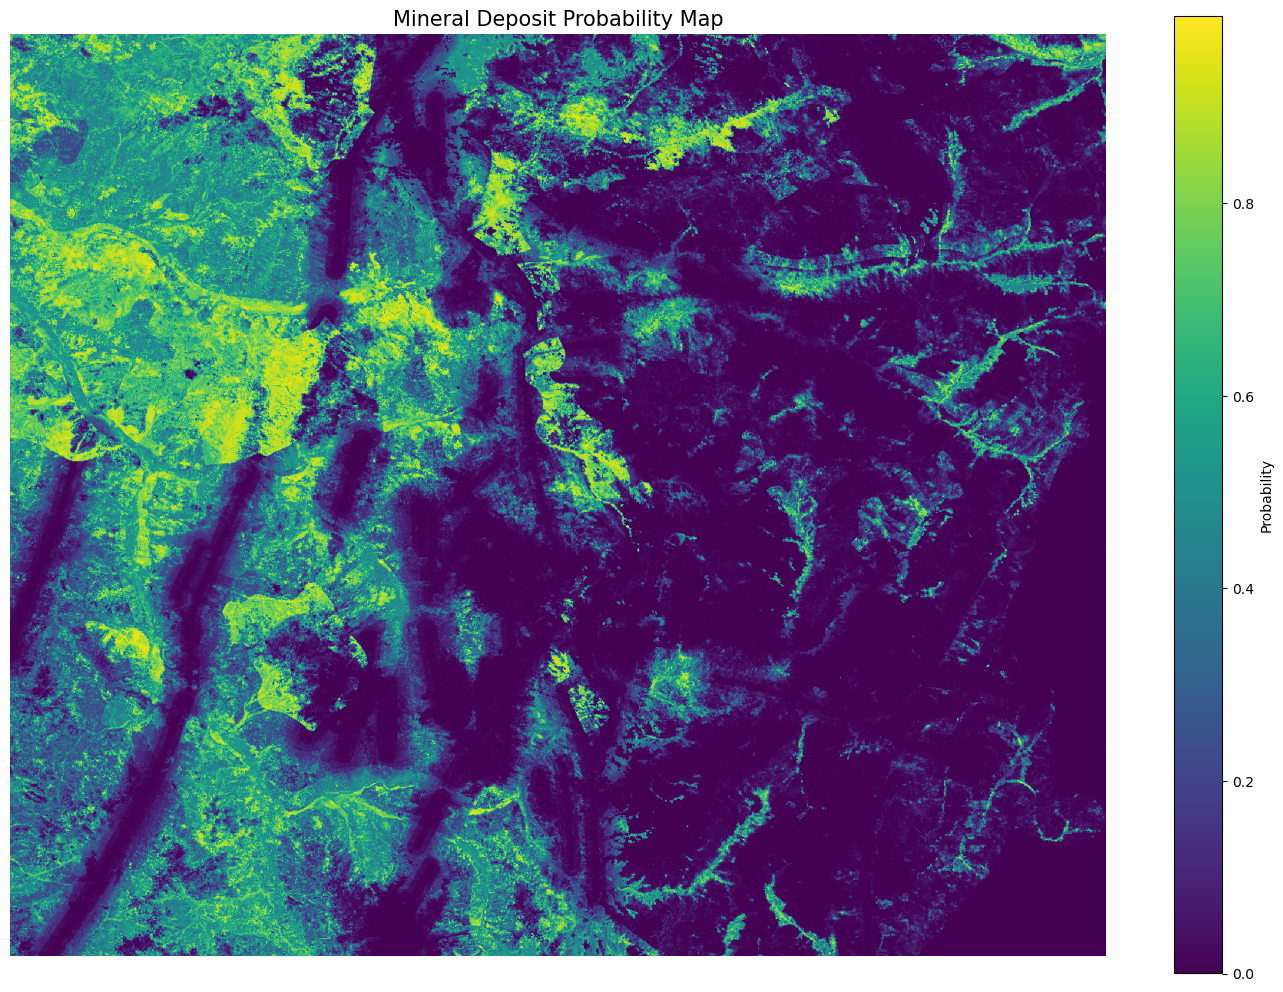

In [114]:
# Plot the probability map
plt.figure(figsize=(14, 10))
plt.imshow(prob_map, cmap='viridis')
plt.colorbar(label='Probability')
plt.title('Mineral Deposit Probability Map', fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

In [115]:
#EXPORT TIF

# Prompt the user to select the destination path and file name
root = Tk()
root.withdraw()  # Hide the root window
root.attributes("-topmost", True)
output_file = asksaveasfilename(
    initialfile="output_prob.tif",
    defaultextension=".tif",
    filetypes=[("TIFF files", "*.tif"), ("All files", "*.*")],
    title="Save Probability Map as TIFF"
)
root.destroy()

# Proceed only if a file name was provided
if output_file:
    # Save the probability map as a plain TIFF
    with rasterio.open(
        output_file, "w",
        driver="GTiff",
        height=prob_map.shape[0],
        width=prob_map.shape[1],
        count=1,
        dtype=prob_map.dtype
    ) as dst:
        dst.write(prob_map, 1)

    print(f"Probability map saved as '{output_file}'")
else:
    print("No file selected. Probability map not saved.")


Probability map saved as 'C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/1200px_larger_2/checkered_data_200/output_prob_2.tif'


c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\rasterio\__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [117]:

file_paths = [
    r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200px_larger_2\checkered_data_400\output_prob.tif",
    r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200px_larger_2\checkered_data_400\output_prob_2.tif",
    r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200px_larger_2\checkered_data_200\output_prob.tif",
    r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200px_larger_2\checkered_data_200\output_prob_2.tif",
    r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200px_larger_2\checkered_data_600\output_prob.tif",
    r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200px_larger_2\checkered_data_600\output_prob_2.tif"
]

# Initialize an array to store the sum of all 6 TIFF files
sum_array = None

# Loop over each file and add it to the sum
for file_path in file_paths:
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first (or only) band of the TIFF
        
        # Initialize sum_array with the first file's shape and dtype if not done yet
        if sum_array is None:
            sum_array = np.zeros_like(data, dtype=np.float64)  # Use float64 for cumulative sum accuracy

        # Add the current file's data to the sum
        sum_array += data

# Divide the summed array by 6 to get the average
average_array = sum_array / len(file_paths)


c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


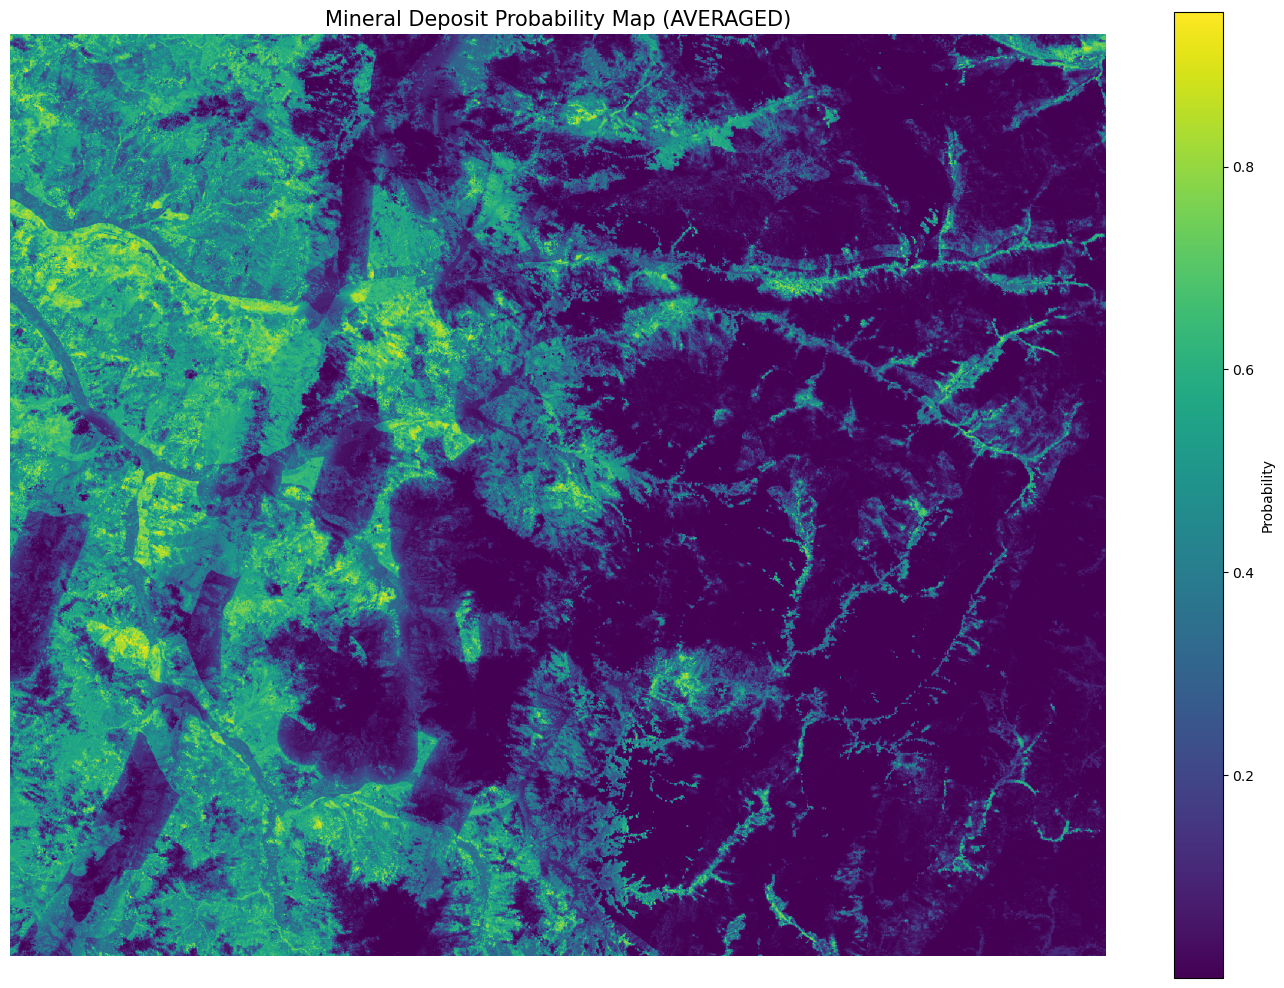

In [120]:
# Plot the averaged probability map
plt.figure(figsize=(14, 10))
plt.imshow(average_array, cmap='viridis')
plt.colorbar(label='Probability')
plt.title('Mineral Deposit Probability Map (AVERAGED)', fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

In [122]:

# Define the output path for the averaged result
output_file = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200px_larger_2\average_result.tif"

# Save the averaged array as a new TIFF
with rasterio.open(
    file_paths[0]  # Use the first file's metadata as a template
) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float64)

    with rasterio.open(output_file, "w", **profile) as dst:
        dst.write(average_array, 1)  # Write the result to the first band

print(f"Averaged result saved as '{output_file}'")

Averaged result saved as 'C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200px_larger_2\average_result.tif'


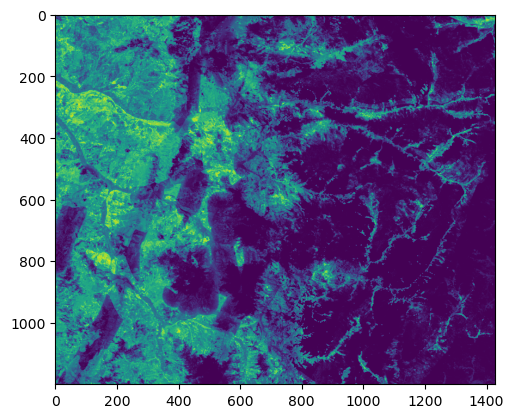

In [123]:
test_import = None

with rasterio.open(r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\ML_Pilot_Tyler_Data\1200px_larger_2\average_result.tif") as src:
        data = src.read(1)  # Read the first (or only) band of the TIFF
        
        # Initialize sum_array with the first file's shape and dtype if not done yet
        if test_import is None:
            test_import = np.zeros_like(data, dtype=np.float64)  # Use float64 for cumulative sum accuracy

        # Add the current file's data to the sum
        test_import += data


plt.imshow(test_import)